In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import optimizers

In [2]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/p2p/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


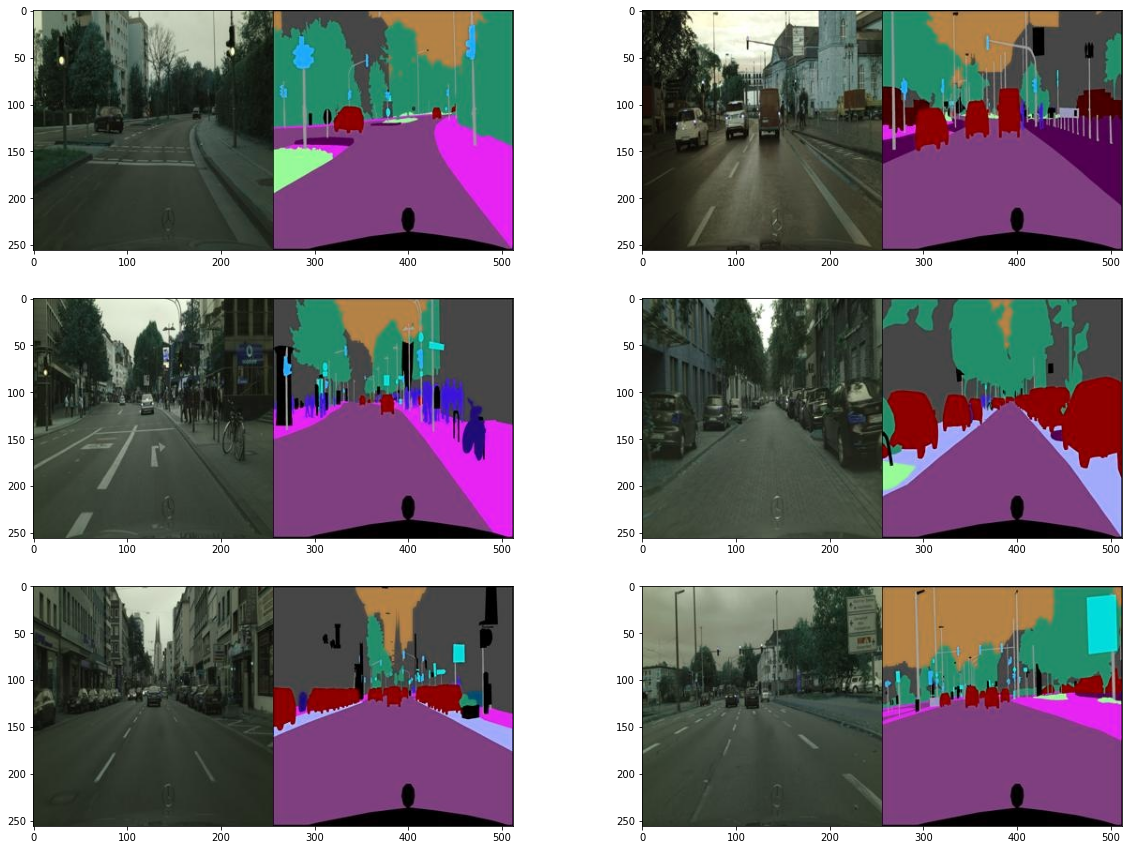

In [3]:
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


In [5]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :] 
    colored = tf.cast(colored, tf.float32)
    sketch = img[:, w:, :] 
    sketch = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

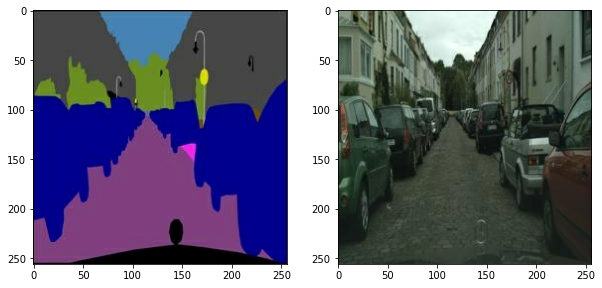

In [6]:
f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

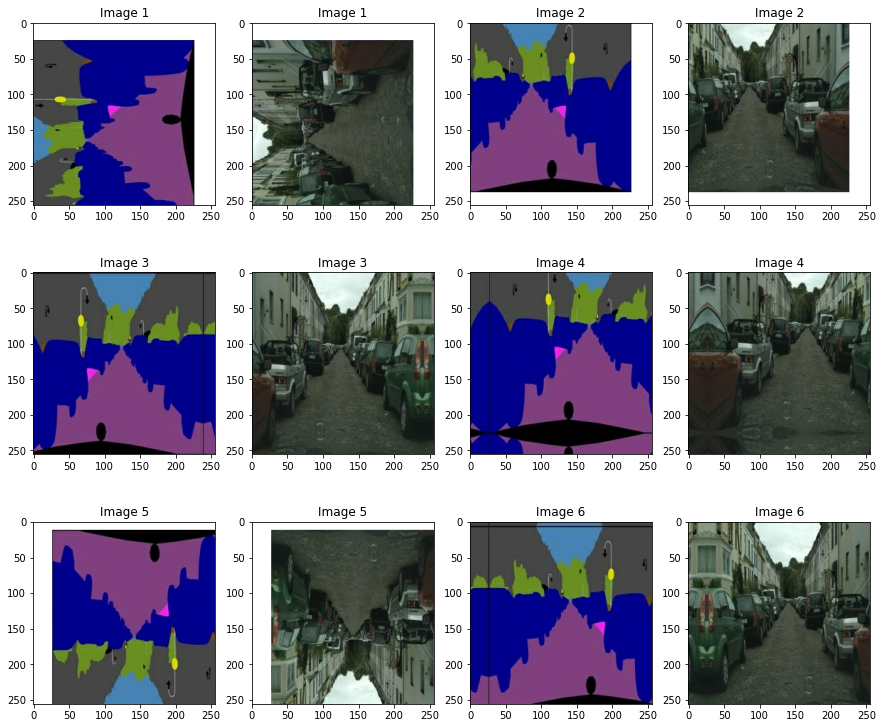

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

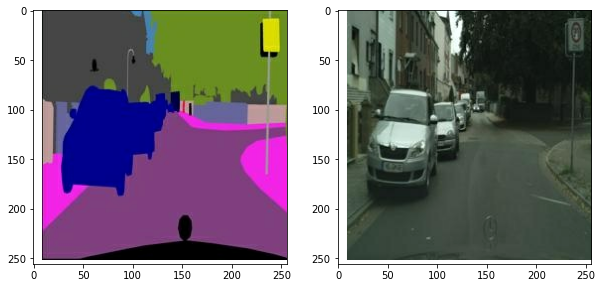

In [9]:
def get_train(img_path):
    sketch, colored  = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

In [10]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [11]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        # for문과 리스트 filter를 활용해서 EncoderBlock을 쌓아주세요.
        # 조건 1. 첫번째 EncoderBlock의 경우 Batch Normalization을 생략해주세요.
        self.blocks = [] 
        for i,f in enumerate(filters):
            self.blocks.append(
                EncodeBlock(f,use_bn=False if i==0 else True)
            )
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [12]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        # for문을 이용해서 모델을 쌓아주세요.
        # 조건 1. 3번째 block까지는 Dropout을 사용하되 그 이후에는 Dropout을 사용하지 마세요.
        # for문이 끝난 다음 Conv2DTranspose를 쌓아주되 output 차원수는 3, filter 사이즈는 4, stride는 2로 구성해주시고 자동 패딩 적용해주시되 bias는 사용하지 않습니다.
        self.blocks = []
        for i,f in enumerate(filters):
            self.blocks.append(
                DecodeBlock(f,dropout=True if i<3 else False)
            )
        self.blocks.append(
            layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
        )
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [13]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [14]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [15]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [16]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        filters = [64,128,256,512,1]
        self.blocks = [layers.Concatenate()]
        for i,f in enumerate(filters) :
            # (self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True)
            self.blocks.append(
                DiscBlock(
                    f,
                    stride=2 if i<=2 else 1,
                    custom_pad=False if i<=2 else True,
                    use_bn=False if i!=0 and i!=4 else True,
                    act = True if i<=3 else False
                    )
            )
        self.sigmoid = layers.Activation(tf.nn.sigmoid)

        # For문을 활용해서 DiscBlock을 쌓아주세요.
        # 조건 1 : 3번째까지 stride는 2로 주되 이후에는 1로 주세요
        # 조건 2 : 3번째까지 custom padding을 주지 않아도 되는데 이후에는 주세요.
        # 조건 3: 1번째와 5번째에서는 Batch Normalization을 사용하지 마세요.
        # 조건 4 : 1번째부터 4번째까지 LeakyReLU를 적용하고 마지막에는 sigmoid를 적용하세요. (sigmoid의 경우 따로 정의해야 합니다)
    
    def call(self, x, y):
        #[[YOUR CODE]]
        out = self.blocks[0]([x,y])
        for i,b in enumerate(self.blocks) :
            if i ==0 :
                continue
            out = b(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [17]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [18]:
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [19]:
generator = UNetGenerator()
discriminator = Discriminator()

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
    # 이전에 배웠던 내용을 토대로 train_step을 구성해주세요.
        # Generator를 이용해 가짜 이미지 생성
        fake_images = generator(sketch)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = discriminator(sketch,real_colored)
        fake_out = discriminator(sketch, fake_images)
        # 각 손실(loss)을 계산
        gene_loss,l1_loss = get_gene_loss(fake_images, real_colored, fake_out)
        disc_loss = get_disc_loss(fake_out, real_out)
    
    gene_gradient = gene_tape.gradient(gene_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    

    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [20]:
EPOCHS = 100

g_loss_his = []
l1_loss_his = []
d_loss_his = []
for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            g_loss_his.append(g_loss)        
            l1_loss_his.append(l1_loss)
            d_loss_his.append(d_loss)
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:127.0003                     
L1_loss:7.5935                     
Discriminator_loss:9.3993

EPOCH[1] - STEP[20]                     
Generator_loss:0.9670                     
L1_loss:0.5140                     
Discriminator_loss:0.6492

EPOCH[1] - STEP[30]                     
Generator_loss:6.4320                     
L1_loss:2.4181                     
Discriminator_loss:1.6785

EPOCH[1] - STEP[40]                     
Generator_loss:0.7318                     
L1_loss:0.4078                     
Discriminator_loss:1.2729

EPOCH[1] - STEP[50]                     
Generator_loss:0.8809                     
L1_loss:0.3661                     
Discriminator_loss:0.9257

EPOCH[1] - STEP[60]                     
Generator_loss:0.3136                     
L1_loss:0.7549                     
Discriminator_loss:2.3871

EPOCH[1] - STEP[70]                     
Generator_loss:1.2179                     
L1_loss:0.4682                  

EPOCH[3] - STEP[70]                     
Generator_loss:1.0019                     
L1_loss:0.2939                     
Discriminator_loss:1.1450

EPOCH[3] - STEP[80]                     
Generator_loss:0.8908                     
L1_loss:0.3146                     
Discriminator_loss:1.0951

EPOCH[3] - STEP[90]                     
Generator_loss:0.9692                     
L1_loss:0.3721                     
Discriminator_loss:0.8826

EPOCH[3] - STEP[100]                     
Generator_loss:1.2759                     
L1_loss:0.3797                     
Discriminator_loss:1.0237

EPOCH[3] - STEP[110]                     
Generator_loss:0.6267                     
L1_loss:0.4606                     
Discriminator_loss:1.8039

EPOCH[3] - STEP[120]                     
Generator_loss:1.6563                     
L1_loss:0.3380                     
Discriminator_loss:1.1438

EPOCH[3] - STEP[130]                     
Generator_loss:1.9142                     
L1_loss:0.4308                

EPOCH[5] - STEP[130]                     
Generator_loss:1.2570                     
L1_loss:0.5299                     
Discriminator_loss:0.8305

EPOCH[5] - STEP[140]                     
Generator_loss:1.1199                     
L1_loss:0.5927                     
Discriminator_loss:1.1099

EPOCH[5] - STEP[150]                     
Generator_loss:1.4865                     
L1_loss:0.5137                     
Discriminator_loss:0.9646

EPOCH[5] - STEP[160]                     
Generator_loss:1.1170                     
L1_loss:0.3408                     
Discriminator_loss:1.1529

EPOCH[5] - STEP[170]                     
Generator_loss:1.0975                     
L1_loss:0.3706                     
Discriminator_loss:1.0357

EPOCH[5] - STEP[180]                     
Generator_loss:1.2427                     
L1_loss:0.5558                     
Discriminator_loss:1.1685

EPOCH[5] - STEP[190]                     
Generator_loss:1.1771                     
L1_loss:0.4242             

EPOCH[7] - STEP[190]                     
Generator_loss:1.0484                     
L1_loss:0.2993                     
Discriminator_loss:1.3889

EPOCH[7] - STEP[200]                     
Generator_loss:0.9985                     
L1_loss:0.4127                     
Discriminator_loss:1.0713

EPOCH[7] - STEP[210]                     
Generator_loss:0.7624                     
L1_loss:0.2508                     
Discriminator_loss:1.1653

EPOCH[7] - STEP[220]                     
Generator_loss:0.8660                     
L1_loss:0.3067                     
Discriminator_loss:1.2773

EPOCH[7] - STEP[230]                     
Generator_loss:1.6890                     
L1_loss:0.3145                     
Discriminator_loss:1.3515

EPOCH[7] - STEP[240]                     
Generator_loss:0.7960                     
L1_loss:0.2612                     
Discriminator_loss:1.2530

EPOCH[7] - STEP[250]                     
Generator_loss:0.7912                     
L1_loss:0.2405             

EPOCH[9] - STEP[250]                     
Generator_loss:0.8492                     
L1_loss:0.3769                     
Discriminator_loss:1.2669

EPOCH[10] - STEP[10]                     
Generator_loss:0.8202                     
L1_loss:0.2571                     
Discriminator_loss:1.1956

EPOCH[10] - STEP[20]                     
Generator_loss:0.6393                     
L1_loss:0.2928                     
Discriminator_loss:1.4721

EPOCH[10] - STEP[30]                     
Generator_loss:0.9933                     
L1_loss:0.2990                     
Discriminator_loss:1.0786

EPOCH[10] - STEP[40]                     
Generator_loss:1.0681                     
L1_loss:0.2949                     
Discriminator_loss:1.2782

EPOCH[10] - STEP[50]                     
Generator_loss:1.5050                     
L1_loss:0.5243                     
Discriminator_loss:1.3845

EPOCH[10] - STEP[60]                     
Generator_loss:0.6079                     
L1_loss:0.3093             

EPOCH[12] - STEP[60]                     
Generator_loss:0.4016                     
L1_loss:0.2780                     
Discriminator_loss:1.6401

EPOCH[12] - STEP[70]                     
Generator_loss:0.7062                     
L1_loss:0.2708                     
Discriminator_loss:1.3462

EPOCH[12] - STEP[80]                     
Generator_loss:0.7397                     
L1_loss:0.2704                     
Discriminator_loss:1.4634

EPOCH[12] - STEP[90]                     
Generator_loss:0.7505                     
L1_loss:0.3176                     
Discriminator_loss:1.2211

EPOCH[12] - STEP[100]                     
Generator_loss:0.8134                     
L1_loss:0.2851                     
Discriminator_loss:1.3357

EPOCH[12] - STEP[110]                     
Generator_loss:1.0972                     
L1_loss:0.2761                     
Discriminator_loss:1.2065

EPOCH[12] - STEP[120]                     
Generator_loss:1.0789                     
L1_loss:0.3255          

EPOCH[14] - STEP[120]                     
Generator_loss:0.7014                     
L1_loss:0.2196                     
Discriminator_loss:1.3840

EPOCH[14] - STEP[130]                     
Generator_loss:0.8268                     
L1_loss:0.2424                     
Discriminator_loss:1.1824

EPOCH[14] - STEP[140]                     
Generator_loss:0.7642                     
L1_loss:0.2733                     
Discriminator_loss:1.3213

EPOCH[14] - STEP[150]                     
Generator_loss:1.0382                     
L1_loss:0.2827                     
Discriminator_loss:1.1249

EPOCH[14] - STEP[160]                     
Generator_loss:0.9356                     
L1_loss:0.2777                     
Discriminator_loss:1.1639

EPOCH[14] - STEP[170]                     
Generator_loss:0.9452                     
L1_loss:0.2454                     
Discriminator_loss:1.2344

EPOCH[14] - STEP[180]                     
Generator_loss:0.7170                     
L1_loss:0.2491      

EPOCH[16] - STEP[180]                     
Generator_loss:0.7250                     
L1_loss:0.3226                     
Discriminator_loss:1.4214

EPOCH[16] - STEP[190]                     
Generator_loss:0.9196                     
L1_loss:0.2447                     
Discriminator_loss:1.2408

EPOCH[16] - STEP[200]                     
Generator_loss:1.1127                     
L1_loss:0.3224                     
Discriminator_loss:1.0689

EPOCH[16] - STEP[210]                     
Generator_loss:0.7554                     
L1_loss:0.2721                     
Discriminator_loss:1.2222

EPOCH[16] - STEP[220]                     
Generator_loss:0.8338                     
L1_loss:0.2813                     
Discriminator_loss:1.3162

EPOCH[16] - STEP[230]                     
Generator_loss:0.8154                     
L1_loss:0.2923                     
Discriminator_loss:0.9464

EPOCH[16] - STEP[240]                     
Generator_loss:0.6954                     
L1_loss:0.2595      

EPOCH[18] - STEP[240]                     
Generator_loss:0.7967                     
L1_loss:0.2837                     
Discriminator_loss:1.2470

EPOCH[18] - STEP[250]                     
Generator_loss:1.1065                     
L1_loss:0.2568                     
Discriminator_loss:1.2460

EPOCH[19] - STEP[10]                     
Generator_loss:0.8733                     
L1_loss:0.2745                     
Discriminator_loss:1.2494

EPOCH[19] - STEP[20]                     
Generator_loss:0.6821                     
L1_loss:0.2703                     
Discriminator_loss:1.3340

EPOCH[19] - STEP[30]                     
Generator_loss:0.9072                     
L1_loss:0.2223                     
Discriminator_loss:1.2400

EPOCH[19] - STEP[40]                     
Generator_loss:0.7770                     
L1_loss:0.2928                     
Discriminator_loss:1.2542

EPOCH[19] - STEP[50]                     
Generator_loss:0.8311                     
L1_loss:0.2499           

EPOCH[21] - STEP[50]                     
Generator_loss:0.7220                     
L1_loss:0.2259                     
Discriminator_loss:1.3061

EPOCH[21] - STEP[60]                     
Generator_loss:0.8216                     
L1_loss:0.3204                     
Discriminator_loss:1.4584

EPOCH[21] - STEP[70]                     
Generator_loss:0.8454                     
L1_loss:0.2187                     
Discriminator_loss:1.3212

EPOCH[21] - STEP[80]                     
Generator_loss:0.9022                     
L1_loss:0.2280                     
Discriminator_loss:1.1788

EPOCH[21] - STEP[90]                     
Generator_loss:0.9358                     
L1_loss:0.2746                     
Discriminator_loss:1.2511

EPOCH[21] - STEP[100]                     
Generator_loss:0.1988                     
L1_loss:0.2438                     
Discriminator_loss:2.3882

EPOCH[21] - STEP[110]                     
Generator_loss:0.9718                     
L1_loss:0.2358           

EPOCH[23] - STEP[110]                     
Generator_loss:0.7736                     
L1_loss:0.2491                     
Discriminator_loss:1.2455

EPOCH[23] - STEP[120]                     
Generator_loss:1.1123                     
L1_loss:0.2529                     
Discriminator_loss:1.0385

EPOCH[23] - STEP[130]                     
Generator_loss:0.9674                     
L1_loss:0.2600                     
Discriminator_loss:0.8901

EPOCH[23] - STEP[140]                     
Generator_loss:0.7685                     
L1_loss:0.2331                     
Discriminator_loss:1.3153

EPOCH[23] - STEP[150]                     
Generator_loss:0.8155                     
L1_loss:0.2078                     
Discriminator_loss:1.3278

EPOCH[23] - STEP[160]                     
Generator_loss:0.6731                     
L1_loss:0.2488                     
Discriminator_loss:1.2503

EPOCH[23] - STEP[170]                     
Generator_loss:0.9295                     
L1_loss:0.2422      

EPOCH[25] - STEP[170]                     
Generator_loss:0.9117                     
L1_loss:0.2220                     
Discriminator_loss:1.0970

EPOCH[25] - STEP[180]                     
Generator_loss:0.9014                     
L1_loss:0.2603                     
Discriminator_loss:1.1098

EPOCH[25] - STEP[190]                     
Generator_loss:1.0574                     
L1_loss:0.2201                     
Discriminator_loss:1.2045

EPOCH[25] - STEP[200]                     
Generator_loss:0.6445                     
L1_loss:0.2720                     
Discriminator_loss:1.3958

EPOCH[25] - STEP[210]                     
Generator_loss:1.0576                     
L1_loss:0.2447                     
Discriminator_loss:0.8612

EPOCH[25] - STEP[220]                     
Generator_loss:0.9024                     
L1_loss:0.2343                     
Discriminator_loss:0.8082

EPOCH[25] - STEP[230]                     
Generator_loss:0.9426                     
L1_loss:0.3336      

EPOCH[27] - STEP[230]                     
Generator_loss:0.8387                     
L1_loss:0.2388                     
Discriminator_loss:1.1041

EPOCH[27] - STEP[240]                     
Generator_loss:1.3601                     
L1_loss:0.2286                     
Discriminator_loss:0.9929

EPOCH[27] - STEP[250]                     
Generator_loss:0.9355                     
L1_loss:0.2768                     
Discriminator_loss:0.8756

EPOCH[28] - STEP[10]                     
Generator_loss:1.1024                     
L1_loss:0.2382                     
Discriminator_loss:1.0925

EPOCH[28] - STEP[20]                     
Generator_loss:0.6444                     
L1_loss:0.2679                     
Discriminator_loss:1.4231

EPOCH[28] - STEP[30]                     
Generator_loss:0.9270                     
L1_loss:0.2514                     
Discriminator_loss:1.0425

EPOCH[28] - STEP[40]                     
Generator_loss:1.3596                     
L1_loss:0.1904          

EPOCH[30] - STEP[40]                     
Generator_loss:1.1938                     
L1_loss:0.2094                     
Discriminator_loss:1.5451

EPOCH[30] - STEP[50]                     
Generator_loss:1.1477                     
L1_loss:0.2404                     
Discriminator_loss:0.9806

EPOCH[30] - STEP[60]                     
Generator_loss:0.8131                     
L1_loss:0.2359                     
Discriminator_loss:1.0949

EPOCH[30] - STEP[70]                     
Generator_loss:1.0414                     
L1_loss:0.2817                     
Discriminator_loss:1.2371

EPOCH[30] - STEP[80]                     
Generator_loss:1.0815                     
L1_loss:0.2662                     
Discriminator_loss:1.4268

EPOCH[30] - STEP[90]                     
Generator_loss:0.9891                     
L1_loss:0.2510                     
Discriminator_loss:0.6920

EPOCH[30] - STEP[100]                     
Generator_loss:1.1817                     
L1_loss:0.2611            

EPOCH[32] - STEP[100]                     
Generator_loss:1.2660                     
L1_loss:0.2962                     
Discriminator_loss:0.9648

EPOCH[32] - STEP[110]                     
Generator_loss:0.7555                     
L1_loss:0.2310                     
Discriminator_loss:0.9480

EPOCH[32] - STEP[120]                     
Generator_loss:0.6668                     
L1_loss:0.2575                     
Discriminator_loss:1.0849

EPOCH[32] - STEP[130]                     
Generator_loss:0.8401                     
L1_loss:0.2434                     
Discriminator_loss:1.3494

EPOCH[32] - STEP[140]                     
Generator_loss:1.2891                     
L1_loss:0.2670                     
Discriminator_loss:1.8156

EPOCH[32] - STEP[150]                     
Generator_loss:0.6969                     
L1_loss:0.2560                     
Discriminator_loss:1.1164

EPOCH[32] - STEP[160]                     
Generator_loss:1.3471                     
L1_loss:0.2854      

EPOCH[34] - STEP[160]                     
Generator_loss:0.6654                     
L1_loss:0.2587                     
Discriminator_loss:1.3611

EPOCH[34] - STEP[170]                     
Generator_loss:0.6100                     
L1_loss:0.2818                     
Discriminator_loss:1.6749

EPOCH[34] - STEP[180]                     
Generator_loss:0.7122                     
L1_loss:0.1965                     
Discriminator_loss:1.3828

EPOCH[34] - STEP[190]                     
Generator_loss:0.7250                     
L1_loss:0.2605                     
Discriminator_loss:1.2762

EPOCH[34] - STEP[200]                     
Generator_loss:0.9080                     
L1_loss:0.2174                     
Discriminator_loss:1.2162

EPOCH[34] - STEP[210]                     
Generator_loss:0.8670                     
L1_loss:0.2218                     
Discriminator_loss:1.1845

EPOCH[34] - STEP[220]                     
Generator_loss:0.7073                     
L1_loss:0.2326      

EPOCH[36] - STEP[220]                     
Generator_loss:0.6283                     
L1_loss:0.2800                     
Discriminator_loss:1.3683

EPOCH[36] - STEP[230]                     
Generator_loss:1.1573                     
L1_loss:0.1952                     
Discriminator_loss:0.9212

EPOCH[36] - STEP[240]                     
Generator_loss:0.7660                     
L1_loss:0.2234                     
Discriminator_loss:1.3938

EPOCH[36] - STEP[250]                     
Generator_loss:0.8999                     
L1_loss:0.2062                     
Discriminator_loss:1.2822

EPOCH[37] - STEP[10]                     
Generator_loss:0.7382                     
L1_loss:0.2269                     
Discriminator_loss:1.2746

EPOCH[37] - STEP[20]                     
Generator_loss:0.7943                     
L1_loss:0.2108                     
Discriminator_loss:1.1422

EPOCH[37] - STEP[30]                     
Generator_loss:0.7096                     
L1_loss:0.2456         

EPOCH[39] - STEP[30]                     
Generator_loss:1.1168                     
L1_loss:0.2589                     
Discriminator_loss:1.4287

EPOCH[39] - STEP[40]                     
Generator_loss:0.8502                     
L1_loss:0.2092                     
Discriminator_loss:1.3288

EPOCH[39] - STEP[50]                     
Generator_loss:1.1916                     
L1_loss:0.3391                     
Discriminator_loss:1.1318

EPOCH[39] - STEP[60]                     
Generator_loss:0.6988                     
L1_loss:0.2843                     
Discriminator_loss:1.2393

EPOCH[39] - STEP[70]                     
Generator_loss:0.6714                     
L1_loss:0.2312                     
Discriminator_loss:1.3564

EPOCH[39] - STEP[80]                     
Generator_loss:0.7288                     
L1_loss:0.2697                     
Discriminator_loss:1.1757

EPOCH[39] - STEP[90]                     
Generator_loss:0.9991                     
L1_loss:0.2360             

EPOCH[41] - STEP[90]                     
Generator_loss:0.7646                     
L1_loss:0.1899                     
Discriminator_loss:1.2396

EPOCH[41] - STEP[100]                     
Generator_loss:1.0143                     
L1_loss:0.2991                     
Discriminator_loss:1.1024

EPOCH[41] - STEP[110]                     
Generator_loss:1.5927                     
L1_loss:0.2132                     
Discriminator_loss:0.5305

EPOCH[41] - STEP[120]                     
Generator_loss:1.0291                     
L1_loss:0.2543                     
Discriminator_loss:0.8041

EPOCH[41] - STEP[130]                     
Generator_loss:0.8592                     
L1_loss:0.2359                     
Discriminator_loss:1.2653

EPOCH[41] - STEP[140]                     
Generator_loss:0.1516                     
L1_loss:0.2340                     
Discriminator_loss:3.0926

EPOCH[41] - STEP[150]                     
Generator_loss:0.8178                     
L1_loss:0.2961       

EPOCH[43] - STEP[150]                     
Generator_loss:1.2180                     
L1_loss:0.2134                     
Discriminator_loss:0.9726

EPOCH[43] - STEP[160]                     
Generator_loss:0.9039                     
L1_loss:0.3018                     
Discriminator_loss:0.9811

EPOCH[43] - STEP[170]                     
Generator_loss:1.0348                     
L1_loss:0.2493                     
Discriminator_loss:1.0254

EPOCH[43] - STEP[180]                     
Generator_loss:1.2426                     
L1_loss:0.2365                     
Discriminator_loss:1.2941

EPOCH[43] - STEP[190]                     
Generator_loss:0.9424                     
L1_loss:0.3342                     
Discriminator_loss:1.2679

EPOCH[43] - STEP[200]                     
Generator_loss:0.8958                     
L1_loss:0.2416                     
Discriminator_loss:1.0574

EPOCH[43] - STEP[210]                     
Generator_loss:0.8693                     
L1_loss:0.2629      

EPOCH[45] - STEP[210]                     
Generator_loss:0.7984                     
L1_loss:0.2728                     
Discriminator_loss:0.8937

EPOCH[45] - STEP[220]                     
Generator_loss:0.7338                     
L1_loss:0.2553                     
Discriminator_loss:1.0516

EPOCH[45] - STEP[230]                     
Generator_loss:0.9281                     
L1_loss:0.1969                     
Discriminator_loss:1.3053

EPOCH[45] - STEP[240]                     
Generator_loss:0.7975                     
L1_loss:0.2159                     
Discriminator_loss:1.1274

EPOCH[45] - STEP[250]                     
Generator_loss:1.5805                     
L1_loss:0.1965                     
Discriminator_loss:0.7229

EPOCH[46] - STEP[10]                     
Generator_loss:0.9516                     
L1_loss:0.3053                     
Discriminator_loss:1.0139

EPOCH[46] - STEP[20]                     
Generator_loss:0.8250                     
L1_loss:0.2037        

EPOCH[48] - STEP[20]                     
Generator_loss:1.0766                     
L1_loss:0.2389                     
Discriminator_loss:0.7646

EPOCH[48] - STEP[30]                     
Generator_loss:1.2360                     
L1_loss:0.2307                     
Discriminator_loss:0.6382

EPOCH[48] - STEP[40]                     
Generator_loss:1.0067                     
L1_loss:0.2541                     
Discriminator_loss:1.0559

EPOCH[48] - STEP[50]                     
Generator_loss:0.7852                     
L1_loss:0.1722                     
Discriminator_loss:0.9528

EPOCH[48] - STEP[60]                     
Generator_loss:0.8898                     
L1_loss:0.2688                     
Discriminator_loss:1.0616

EPOCH[48] - STEP[70]                     
Generator_loss:1.0489                     
L1_loss:0.1986                     
Discriminator_loss:0.6549

EPOCH[48] - STEP[80]                     
Generator_loss:1.1301                     
L1_loss:0.2238             

EPOCH[50] - STEP[80]                     
Generator_loss:1.0692                     
L1_loss:0.2673                     
Discriminator_loss:1.1102

EPOCH[50] - STEP[90]                     
Generator_loss:0.8375                     
L1_loss:0.2538                     
Discriminator_loss:1.3076

EPOCH[50] - STEP[100]                     
Generator_loss:1.0082                     
L1_loss:0.1951                     
Discriminator_loss:1.2975

EPOCH[50] - STEP[110]                     
Generator_loss:0.7953                     
L1_loss:0.2263                     
Discriminator_loss:1.2503

EPOCH[50] - STEP[120]                     
Generator_loss:0.8776                     
L1_loss:0.2007                     
Discriminator_loss:1.2751

EPOCH[50] - STEP[130]                     
Generator_loss:0.8941                     
L1_loss:0.2017                     
Discriminator_loss:1.0046

EPOCH[50] - STEP[140]                     
Generator_loss:1.4043                     
L1_loss:0.2493        

EPOCH[52] - STEP[140]                     
Generator_loss:1.3070                     
L1_loss:0.4405                     
Discriminator_loss:1.0086

EPOCH[52] - STEP[150]                     
Generator_loss:1.1993                     
L1_loss:0.3271                     
Discriminator_loss:1.5205

EPOCH[52] - STEP[160]                     
Generator_loss:0.8801                     
L1_loss:0.1968                     
Discriminator_loss:0.9516

EPOCH[52] - STEP[170]                     
Generator_loss:1.0057                     
L1_loss:0.2294                     
Discriminator_loss:1.2642

EPOCH[52] - STEP[180]                     
Generator_loss:0.8285                     
L1_loss:0.2082                     
Discriminator_loss:1.1161

EPOCH[52] - STEP[190]                     
Generator_loss:0.6162                     
L1_loss:0.2572                     
Discriminator_loss:1.4991

EPOCH[52] - STEP[200]                     
Generator_loss:0.7109                     
L1_loss:0.2205      

EPOCH[54] - STEP[200]                     
Generator_loss:0.8442                     
L1_loss:0.2404                     
Discriminator_loss:0.9188

EPOCH[54] - STEP[210]                     
Generator_loss:0.5546                     
L1_loss:0.2157                     
Discriminator_loss:1.6753

EPOCH[54] - STEP[220]                     
Generator_loss:1.0390                     
L1_loss:0.2359                     
Discriminator_loss:0.9015

EPOCH[54] - STEP[230]                     
Generator_loss:1.3231                     
L1_loss:0.1884                     
Discriminator_loss:0.9197

EPOCH[54] - STEP[240]                     
Generator_loss:0.6813                     
L1_loss:0.2102                     
Discriminator_loss:1.1772

EPOCH[54] - STEP[250]                     
Generator_loss:0.5833                     
L1_loss:0.2074                     
Discriminator_loss:1.9098

EPOCH[55] - STEP[10]                     
Generator_loss:1.1096                     
L1_loss:0.2329       

EPOCH[57] - STEP[10]                     
Generator_loss:0.9886                     
L1_loss:0.1937                     
Discriminator_loss:0.9416

EPOCH[57] - STEP[20]                     
Generator_loss:0.9877                     
L1_loss:0.2528                     
Discriminator_loss:0.8065

EPOCH[57] - STEP[30]                     
Generator_loss:0.9792                     
L1_loss:0.2470                     
Discriminator_loss:1.1422

EPOCH[57] - STEP[40]                     
Generator_loss:0.9745                     
L1_loss:0.2121                     
Discriminator_loss:0.6355

EPOCH[57] - STEP[50]                     
Generator_loss:0.9499                     
L1_loss:0.2445                     
Discriminator_loss:0.7451

EPOCH[57] - STEP[60]                     
Generator_loss:1.0677                     
L1_loss:0.2475                     
Discriminator_loss:1.3624

EPOCH[57] - STEP[70]                     
Generator_loss:1.1381                     
L1_loss:0.2110             

EPOCH[59] - STEP[70]                     
Generator_loss:0.9487                     
L1_loss:0.1772                     
Discriminator_loss:1.1145

EPOCH[59] - STEP[80]                     
Generator_loss:0.6977                     
L1_loss:0.2774                     
Discriminator_loss:1.5056

EPOCH[59] - STEP[90]                     
Generator_loss:0.8403                     
L1_loss:0.2157                     
Discriminator_loss:1.0119

EPOCH[59] - STEP[100]                     
Generator_loss:0.8263                     
L1_loss:0.2929                     
Discriminator_loss:1.7083

EPOCH[59] - STEP[110]                     
Generator_loss:1.0417                     
L1_loss:0.1864                     
Discriminator_loss:0.9380

EPOCH[59] - STEP[120]                     
Generator_loss:0.8071                     
L1_loss:0.2094                     
Discriminator_loss:0.9993

EPOCH[59] - STEP[130]                     
Generator_loss:0.7473                     
L1_loss:0.3191         

EPOCH[61] - STEP[130]                     
Generator_loss:1.2382                     
L1_loss:0.2709                     
Discriminator_loss:0.9335

EPOCH[61] - STEP[140]                     
Generator_loss:0.9294                     
L1_loss:0.2324                     
Discriminator_loss:1.1740

EPOCH[61] - STEP[150]                     
Generator_loss:0.7446                     
L1_loss:0.2325                     
Discriminator_loss:1.6316

EPOCH[61] - STEP[160]                     
Generator_loss:0.9045                     
L1_loss:0.2101                     
Discriminator_loss:1.4958

EPOCH[61] - STEP[170]                     
Generator_loss:1.0084                     
L1_loss:0.2065                     
Discriminator_loss:1.0000

EPOCH[61] - STEP[180]                     
Generator_loss:1.1429                     
L1_loss:0.2400                     
Discriminator_loss:0.9315

EPOCH[61] - STEP[190]                     
Generator_loss:0.9112                     
L1_loss:0.2435      

EPOCH[63] - STEP[190]                     
Generator_loss:1.2573                     
L1_loss:0.2349                     
Discriminator_loss:1.8873

EPOCH[63] - STEP[200]                     
Generator_loss:0.7066                     
L1_loss:0.2179                     
Discriminator_loss:1.1524

EPOCH[63] - STEP[210]                     
Generator_loss:0.6940                     
L1_loss:0.2034                     
Discriminator_loss:1.6340

EPOCH[63] - STEP[220]                     
Generator_loss:1.2102                     
L1_loss:0.2141                     
Discriminator_loss:0.6881

EPOCH[63] - STEP[230]                     
Generator_loss:0.6479                     
L1_loss:0.1692                     
Discriminator_loss:1.3570

EPOCH[63] - STEP[240]                     
Generator_loss:0.9149                     
L1_loss:0.2101                     
Discriminator_loss:1.2331

EPOCH[63] - STEP[250]                     
Generator_loss:0.7051                     
L1_loss:0.2017      

EPOCH[65] - STEP[250]                     
Generator_loss:0.8625                     
L1_loss:0.2359                     
Discriminator_loss:1.0652

EPOCH[66] - STEP[10]                     
Generator_loss:0.9582                     
L1_loss:0.1852                     
Discriminator_loss:1.0601

EPOCH[66] - STEP[20]                     
Generator_loss:0.8109                     
L1_loss:0.2192                     
Discriminator_loss:1.5158

EPOCH[66] - STEP[30]                     
Generator_loss:1.3279                     
L1_loss:0.1705                     
Discriminator_loss:0.6990

EPOCH[66] - STEP[40]                     
Generator_loss:0.6770                     
L1_loss:0.2147                     
Discriminator_loss:1.1949

EPOCH[66] - STEP[50]                     
Generator_loss:0.3932                     
L1_loss:0.1905                     
Discriminator_loss:1.5041

EPOCH[66] - STEP[60]                     
Generator_loss:1.0018                     
L1_loss:0.2172            

EPOCH[68] - STEP[60]                     
Generator_loss:0.9843                     
L1_loss:0.2414                     
Discriminator_loss:1.4375

EPOCH[68] - STEP[70]                     
Generator_loss:0.8373                     
L1_loss:0.2473                     
Discriminator_loss:1.1764

EPOCH[68] - STEP[80]                     
Generator_loss:1.0664                     
L1_loss:0.2210                     
Discriminator_loss:1.2387

EPOCH[68] - STEP[90]                     
Generator_loss:0.8953                     
L1_loss:0.2616                     
Discriminator_loss:1.3306

EPOCH[68] - STEP[100]                     
Generator_loss:1.2423                     
L1_loss:0.4033                     
Discriminator_loss:0.6169

EPOCH[68] - STEP[110]                     
Generator_loss:1.0982                     
L1_loss:0.2035                     
Discriminator_loss:1.1236

EPOCH[68] - STEP[120]                     
Generator_loss:0.6612                     
L1_loss:0.2097          

EPOCH[70] - STEP[120]                     
Generator_loss:0.9083                     
L1_loss:0.2027                     
Discriminator_loss:1.4421

EPOCH[70] - STEP[130]                     
Generator_loss:1.0469                     
L1_loss:0.2086                     
Discriminator_loss:1.0671

EPOCH[70] - STEP[140]                     
Generator_loss:0.8562                     
L1_loss:0.2659                     
Discriminator_loss:1.1667

EPOCH[70] - STEP[150]                     
Generator_loss:0.6424                     
L1_loss:0.2332                     
Discriminator_loss:1.5351

EPOCH[70] - STEP[160]                     
Generator_loss:0.8319                     
L1_loss:0.2921                     
Discriminator_loss:1.2413

EPOCH[70] - STEP[170]                     
Generator_loss:1.3682                     
L1_loss:0.2681                     
Discriminator_loss:1.6420

EPOCH[70] - STEP[180]                     
Generator_loss:0.7108                     
L1_loss:0.2397      

EPOCH[72] - STEP[180]                     
Generator_loss:0.8357                     
L1_loss:0.2404                     
Discriminator_loss:1.3648

EPOCH[72] - STEP[190]                     
Generator_loss:0.7583                     
L1_loss:0.2625                     
Discriminator_loss:1.1718

EPOCH[72] - STEP[200]                     
Generator_loss:0.9880                     
L1_loss:0.2044                     
Discriminator_loss:1.1917

EPOCH[72] - STEP[210]                     
Generator_loss:0.9581                     
L1_loss:0.2475                     
Discriminator_loss:1.0510

EPOCH[72] - STEP[220]                     
Generator_loss:0.9878                     
L1_loss:0.1932                     
Discriminator_loss:1.1081

EPOCH[72] - STEP[230]                     
Generator_loss:0.2854                     
L1_loss:0.2283                     
Discriminator_loss:2.8759

EPOCH[72] - STEP[240]                     
Generator_loss:0.7001                     
L1_loss:0.2083      

EPOCH[74] - STEP[240]                     
Generator_loss:0.9454                     
L1_loss:0.1896                     
Discriminator_loss:1.1870

EPOCH[74] - STEP[250]                     
Generator_loss:0.8852                     
L1_loss:0.1788                     
Discriminator_loss:1.1275

EPOCH[75] - STEP[10]                     
Generator_loss:0.6844                     
L1_loss:0.2226                     
Discriminator_loss:1.3557

EPOCH[75] - STEP[20]                     
Generator_loss:0.8327                     
L1_loss:0.2061                     
Discriminator_loss:1.6567

EPOCH[75] - STEP[30]                     
Generator_loss:0.9499                     
L1_loss:0.2027                     
Discriminator_loss:1.0587

EPOCH[75] - STEP[40]                     
Generator_loss:0.6699                     
L1_loss:0.3100                     
Discriminator_loss:1.2417

EPOCH[75] - STEP[50]                     
Generator_loss:0.9456                     
L1_loss:0.1897           

EPOCH[77] - STEP[50]                     
Generator_loss:0.8142                     
L1_loss:0.2531                     
Discriminator_loss:1.2959

EPOCH[77] - STEP[60]                     
Generator_loss:0.7712                     
L1_loss:0.1987                     
Discriminator_loss:1.2479

EPOCH[77] - STEP[70]                     
Generator_loss:0.8307                     
L1_loss:0.2374                     
Discriminator_loss:1.2976

EPOCH[77] - STEP[80]                     
Generator_loss:0.7828                     
L1_loss:0.2083                     
Discriminator_loss:1.2115

EPOCH[77] - STEP[90]                     
Generator_loss:0.7970                     
L1_loss:0.2472                     
Discriminator_loss:1.3060

EPOCH[77] - STEP[100]                     
Generator_loss:0.7215                     
L1_loss:0.2454                     
Discriminator_loss:1.5191

EPOCH[77] - STEP[110]                     
Generator_loss:0.7147                     
L1_loss:0.2288           

EPOCH[79] - STEP[110]                     
Generator_loss:0.8257                     
L1_loss:0.2207                     
Discriminator_loss:1.4344

EPOCH[79] - STEP[120]                     
Generator_loss:0.9438                     
L1_loss:0.3077                     
Discriminator_loss:1.1857

EPOCH[79] - STEP[130]                     
Generator_loss:0.8377                     
L1_loss:0.1902                     
Discriminator_loss:1.5907

EPOCH[79] - STEP[140]                     
Generator_loss:0.9130                     
L1_loss:0.1998                     
Discriminator_loss:1.0242

EPOCH[79] - STEP[150]                     
Generator_loss:0.7661                     
L1_loss:0.1891                     
Discriminator_loss:1.3547

EPOCH[79] - STEP[160]                     
Generator_loss:1.2508                     
L1_loss:0.2704                     
Discriminator_loss:1.5414

EPOCH[79] - STEP[170]                     
Generator_loss:0.7376                     
L1_loss:0.2553      

EPOCH[81] - STEP[170]                     
Generator_loss:0.8936                     
L1_loss:0.2115                     
Discriminator_loss:1.0273

EPOCH[81] - STEP[180]                     
Generator_loss:1.0763                     
L1_loss:0.2404                     
Discriminator_loss:1.4421

EPOCH[81] - STEP[190]                     
Generator_loss:1.5995                     
L1_loss:0.2577                     
Discriminator_loss:0.9615

EPOCH[81] - STEP[200]                     
Generator_loss:0.8326                     
L1_loss:0.2288                     
Discriminator_loss:1.1207

EPOCH[81] - STEP[210]                     
Generator_loss:0.8868                     
L1_loss:0.2016                     
Discriminator_loss:0.8919

EPOCH[81] - STEP[220]                     
Generator_loss:0.8537                     
L1_loss:0.2452                     
Discriminator_loss:1.2758

EPOCH[81] - STEP[230]                     
Generator_loss:0.6456                     
L1_loss:0.1879      

EPOCH[83] - STEP[230]                     
Generator_loss:1.0587                     
L1_loss:0.3090                     
Discriminator_loss:1.4070

EPOCH[83] - STEP[240]                     
Generator_loss:1.0471                     
L1_loss:0.2562                     
Discriminator_loss:1.1937

EPOCH[83] - STEP[250]                     
Generator_loss:0.7358                     
L1_loss:0.2459                     
Discriminator_loss:1.2913

EPOCH[84] - STEP[10]                     
Generator_loss:0.8190                     
L1_loss:0.3033                     
Discriminator_loss:1.2079

EPOCH[84] - STEP[20]                     
Generator_loss:0.8816                     
L1_loss:0.2384                     
Discriminator_loss:1.3708

EPOCH[84] - STEP[30]                     
Generator_loss:1.3373                     
L1_loss:0.2084                     
Discriminator_loss:0.9894

EPOCH[84] - STEP[40]                     
Generator_loss:0.8237                     
L1_loss:0.2412          

EPOCH[86] - STEP[40]                     
Generator_loss:0.8675                     
L1_loss:0.2169                     
Discriminator_loss:1.2071

EPOCH[86] - STEP[50]                     
Generator_loss:0.9894                     
L1_loss:0.2118                     
Discriminator_loss:1.3132

EPOCH[86] - STEP[60]                     
Generator_loss:0.6351                     
L1_loss:0.1933                     
Discriminator_loss:1.1232

EPOCH[86] - STEP[70]                     
Generator_loss:0.6017                     
L1_loss:0.2180                     
Discriminator_loss:1.3100

EPOCH[86] - STEP[80]                     
Generator_loss:0.9082                     
L1_loss:0.2288                     
Discriminator_loss:1.1205

EPOCH[86] - STEP[90]                     
Generator_loss:0.8808                     
L1_loss:0.3166                     
Discriminator_loss:0.8707

EPOCH[86] - STEP[100]                     
Generator_loss:0.6790                     
L1_loss:0.2600            

EPOCH[88] - STEP[100]                     
Generator_loss:0.6830                     
L1_loss:0.2494                     
Discriminator_loss:1.6660

EPOCH[88] - STEP[110]                     
Generator_loss:1.0911                     
L1_loss:0.3381                     
Discriminator_loss:1.2246

EPOCH[88] - STEP[120]                     
Generator_loss:1.1552                     
L1_loss:0.2514                     
Discriminator_loss:1.2730

EPOCH[88] - STEP[130]                     
Generator_loss:0.9094                     
L1_loss:0.3513                     
Discriminator_loss:1.0230

EPOCH[88] - STEP[140]                     
Generator_loss:0.7647                     
L1_loss:0.3359                     
Discriminator_loss:1.2893

EPOCH[88] - STEP[150]                     
Generator_loss:0.8558                     
L1_loss:0.2214                     
Discriminator_loss:1.5052

EPOCH[88] - STEP[160]                     
Generator_loss:1.2470                     
L1_loss:0.2113      

EPOCH[90] - STEP[160]                     
Generator_loss:1.0255                     
L1_loss:0.2362                     
Discriminator_loss:1.2478

EPOCH[90] - STEP[170]                     
Generator_loss:1.1160                     
L1_loss:0.2677                     
Discriminator_loss:1.4020

EPOCH[90] - STEP[180]                     
Generator_loss:0.7590                     
L1_loss:0.1854                     
Discriminator_loss:1.3829

EPOCH[90] - STEP[190]                     
Generator_loss:0.8537                     
L1_loss:0.2104                     
Discriminator_loss:1.2734

EPOCH[90] - STEP[200]                     
Generator_loss:0.9638                     
L1_loss:0.2871                     
Discriminator_loss:1.2902

EPOCH[90] - STEP[210]                     
Generator_loss:0.7796                     
L1_loss:0.2481                     
Discriminator_loss:1.5144

EPOCH[90] - STEP[220]                     
Generator_loss:0.7891                     
L1_loss:0.2151      

EPOCH[92] - STEP[220]                     
Generator_loss:0.8885                     
L1_loss:0.2358                     
Discriminator_loss:1.2664

EPOCH[92] - STEP[230]                     
Generator_loss:0.9532                     
L1_loss:0.2214                     
Discriminator_loss:1.3883

EPOCH[92] - STEP[240]                     
Generator_loss:0.8425                     
L1_loss:0.2218                     
Discriminator_loss:0.9509

EPOCH[92] - STEP[250]                     
Generator_loss:0.8939                     
L1_loss:0.2533                     
Discriminator_loss:0.9229

EPOCH[93] - STEP[10]                     
Generator_loss:0.7186                     
L1_loss:0.2088                     
Discriminator_loss:0.9891

EPOCH[93] - STEP[20]                     
Generator_loss:1.1192                     
L1_loss:0.2092                     
Discriminator_loss:1.1109

EPOCH[93] - STEP[30]                     
Generator_loss:0.8534                     
L1_loss:0.1872         

EPOCH[95] - STEP[30]                     
Generator_loss:1.4574                     
L1_loss:0.2320                     
Discriminator_loss:0.9878

EPOCH[95] - STEP[40]                     
Generator_loss:0.6988                     
L1_loss:0.2433                     
Discriminator_loss:1.1914

EPOCH[95] - STEP[50]                     
Generator_loss:0.7463                     
L1_loss:0.1688                     
Discriminator_loss:1.2399

EPOCH[95] - STEP[60]                     
Generator_loss:0.9034                     
L1_loss:0.2016                     
Discriminator_loss:1.4121

EPOCH[95] - STEP[70]                     
Generator_loss:0.9177                     
L1_loss:0.2572                     
Discriminator_loss:0.9503

EPOCH[95] - STEP[80]                     
Generator_loss:1.4138                     
L1_loss:0.1996                     
Discriminator_loss:0.9648

EPOCH[95] - STEP[90]                     
Generator_loss:0.8033                     
L1_loss:0.2125             

EPOCH[97] - STEP[90]                     
Generator_loss:0.6430                     
L1_loss:0.2592                     
Discriminator_loss:1.5356

EPOCH[97] - STEP[100]                     
Generator_loss:0.6923                     
L1_loss:0.2163                     
Discriminator_loss:1.2705

EPOCH[97] - STEP[110]                     
Generator_loss:1.2308                     
L1_loss:0.2036                     
Discriminator_loss:1.1935

EPOCH[97] - STEP[120]                     
Generator_loss:0.8474                     
L1_loss:0.2327                     
Discriminator_loss:1.1138

EPOCH[97] - STEP[130]                     
Generator_loss:1.1086                     
L1_loss:0.1981                     
Discriminator_loss:1.1274

EPOCH[97] - STEP[140]                     
Generator_loss:1.2220                     
L1_loss:0.1896                     
Discriminator_loss:1.4393

EPOCH[97] - STEP[150]                     
Generator_loss:0.5869                     
L1_loss:0.2485       

EPOCH[99] - STEP[150]                     
Generator_loss:0.8133                     
L1_loss:0.2472                     
Discriminator_loss:1.5559

EPOCH[99] - STEP[160]                     
Generator_loss:0.8166                     
L1_loss:0.1825                     
Discriminator_loss:1.2139

EPOCH[99] - STEP[170]                     
Generator_loss:0.8420                     
L1_loss:0.2164                     
Discriminator_loss:1.2963

EPOCH[99] - STEP[180]                     
Generator_loss:1.3025                     
L1_loss:0.3169                     
Discriminator_loss:0.9605

EPOCH[99] - STEP[190]                     
Generator_loss:0.7647                     
L1_loss:0.2114                     
Discriminator_loss:1.4459

EPOCH[99] - STEP[200]                     
Generator_loss:0.6560                     
L1_loss:0.2650                     
Discriminator_loss:1.4005

EPOCH[99] - STEP[210]                     
Generator_loss:0.7916                     
L1_loss:0.2146      

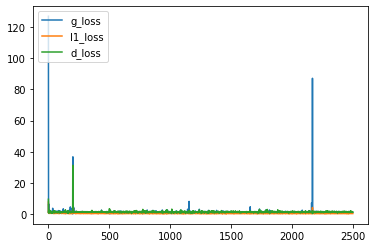

In [23]:
plt.plot(g_loss_his)  
plt.plot(l1_loss_his)
plt.plot(d_loss_his)
plt.legend(['g_loss', 'l1_loss', 'd_loss'], loc='upper left')

plt.show()

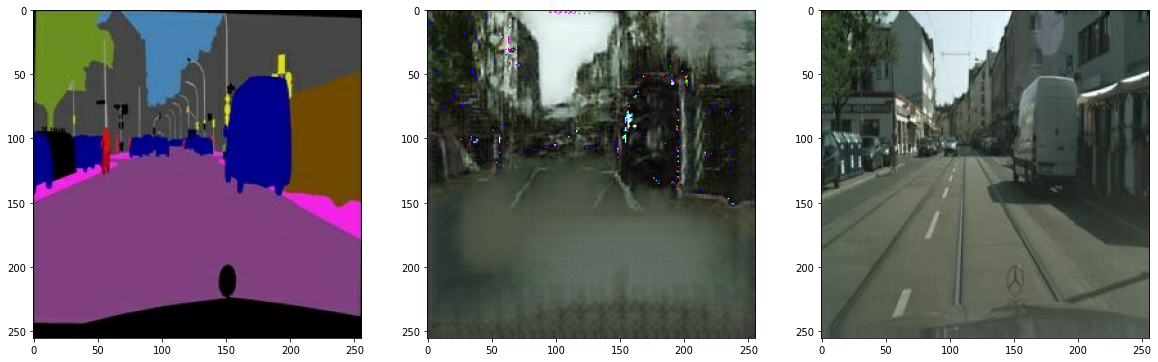

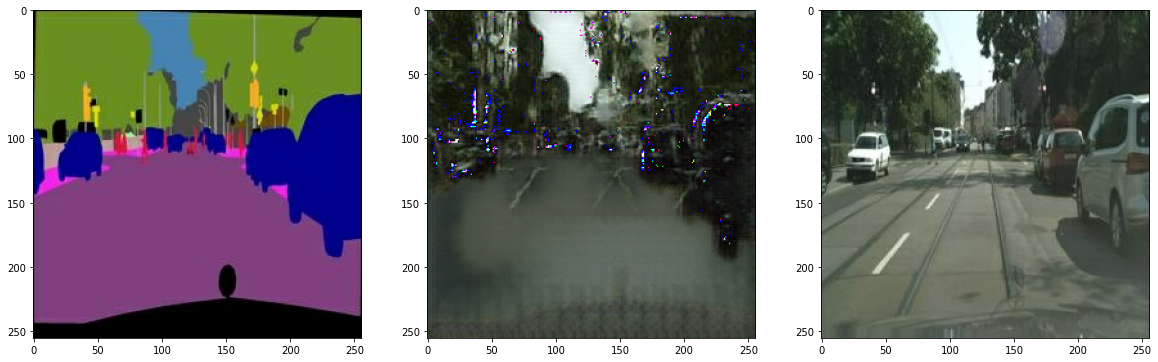

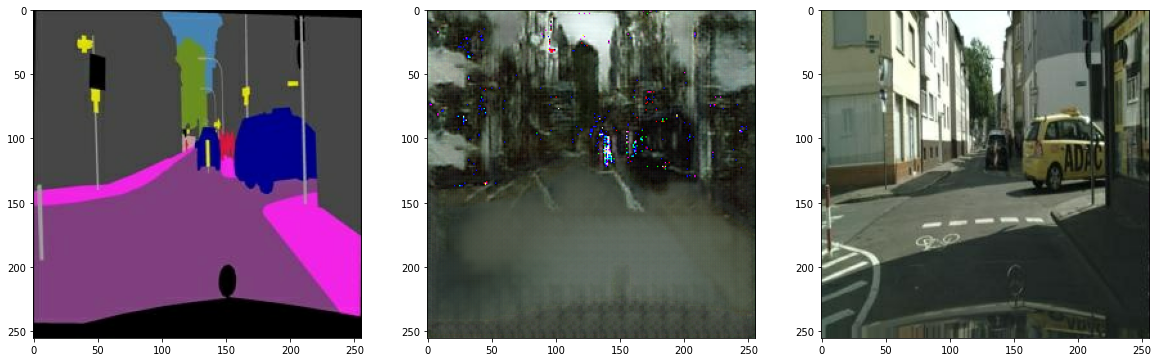

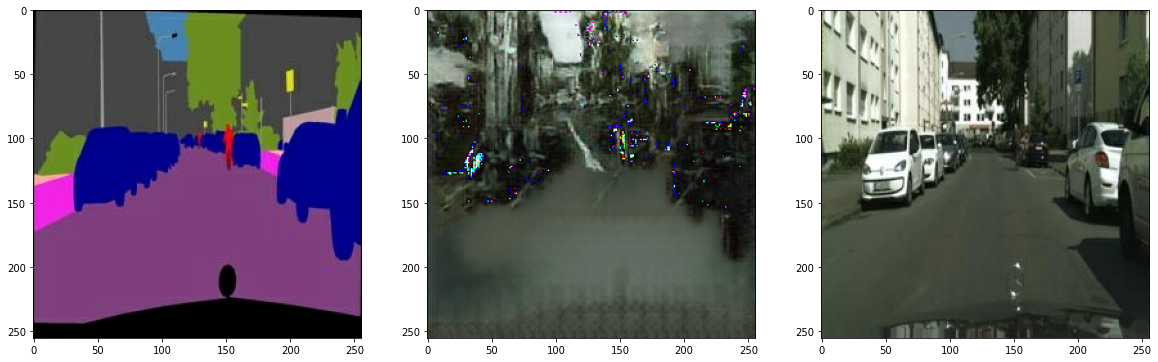

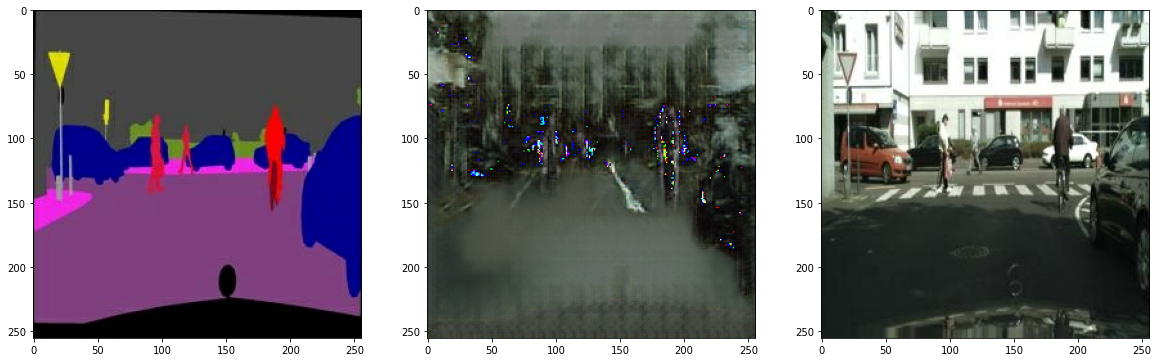

In [24]:
test_path = os.getenv('HOME')+'/aiffel/conditional_generation/p2p/cityscapes/val/'
for file in os.listdir(test_path) :
    f = test_path + file
    sketch, colored = load_img(f)

    pred = generator(tf.expand_dims(sketch, 0))
    pred = denormalize(pred)

    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
    plt.subplot(1,3,2); plt.imshow(pred[0])
    plt.subplot(1,3,3); plt.imshow(denormalize(colored))